In [ ]:
!pip show gensim

In [ ]:
!pip install --upgrade gensim==3.8.3

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

import gensim
from gensim.models import KeyedVectors

from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import re



### 1) 데이터 준비와 확인

In [2]:
from pathlib import Path
directory = Path.joinpath(Path.cwd(),'data')

filename = 'ko.bin' # Filename
word2vec_file_path  = Path.joinpath(directory,filename)
word2vec = gensim.models.Word2Vec.load(str(word2vec_file_path))

# 데이터를 읽어봅시다. 
train_data_path = Path.joinpath(directory, 'ratings_train.txt')
test_data_path  = Path.joinpath(directory, 'ratings_test.txt')

train_data      = pd.read_table(train_data_path)
test_data       = pd.read_table(test_data_path)

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
vocab_size      = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200      # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
BUFFER_SIZE     = 10000
BATCH_SIZE      = 512
epochs          = 15
# steps_per_epoch = 1

# 152,182건의 데이터
# validation set 사이즈
# int_partition = steps_per_epoch * epochs * BATCH_SIZE + 1
int_partition = epochs * BATCH_SIZE + 1

print(int_partition)

7681


### 2) 데이터로더 구성

In [4]:
tokenizer = Mecab()
stopwords = ['남', '수', '거', '기','이', '는', '다', '고', '하', '도', '의', '가', '은', '에', '을', '보', '한', '들', '지', '를', '나', '었', '만']

hangul = re.compile('[^ 가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자

def load_data(train_data, test_data):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        sentence = hangul.sub(" ", sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        sentence = hangul.sub(" ", sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
     
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-4)
    
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)



In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
#모든 문장은 <BOS>로 시작해야 함. 
def get_encoded_sentence(sentence, word_to_index):
    sentence = hangul.sub(" ", sentence) # 한글만 통과
    temp_X = tokenizer.morphs(sentence)  # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거    
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in temp_X]

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [7]:
for i in range(50):
    print(x_train[i])
    print(get_decoded_sentence(x_train[i], index_to_word))
    print('라벨: ', y_train[i])

[19, 57, 862, 25, 201, 20, 682]
더 빙 진짜 짜증 네요 목소리
라벨:  0
[951, 466, 476, 624, 4, 101, 1532, 37, 852, 929, 30, 347]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 않 구나
라벨:  1
[10, 179, 3]
재 
라벨:  0
[8002, 132, 4029, 263, 76, 7, 42, 3300]
이야기 구먼 솔직히 재미 없 평점 조정
라벨:  0
[3, 8457, 1029, 37, 2676, 44, 4, 2604, 26, 1101, 22, 310, 27, 44, 3, 3, 378, 2897, 1652]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 했 던   너무나 이뻐 보였
라벨:  1
[612, 3, 3, 399, 161, 1432, 645, 1580, 653, 35, 3, 4, 2126, 103, 684]
  세 부터 초등 학교 학년 생 인  영화 별반 개 아까움
라벨:  0
[225, 334, 338, 1887, 41, 764]
긴장감 제대로 살려 내 못했
라벨:  0
[204, 1321, 120, 372, 685, 3, 3, 37, 1411, 255, 82, 220, 14, 786, 15, 311, 591, 487, 457, 525, 3142, 8458, 1358, 1358, 55, 267, 7, 37, 86, 60, 3, 29]
반개 아깝 욕 나온다   연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 납치 감금 반복 반복 드라마 가족 없 연기 못 사람  네
라벨:  0
[108, 7, 9, 76, 6, 255, 13, 32, 4]
없 는데 재미 있 몇 안 되 영화
라벨:  1
[48, 595, 42, 213, 686, 519, 72, 462, 1376, 581, 672, 64, 10, 3, 6]
케 평점 낮 건데 꽤 볼 한데 헐리우드 식 화려 함 너무  있
라벨:  1
[3, 25, 202]
진짜 짱
라벨:  1
[72, 62, 389,

In [8]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  11.8576577130015
문장길이 최대 :  71
문장길이 표준편차 :  9.961570575265085
pad_sequences maxlen :  21
전체 문장의 0.8722938071762423%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"]    = 0
word_to_index["<BOS>"]    = 1
word_to_index["<UNK>"]    = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
for i in range(5):
    print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
영화


In [11]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_105/1390784066.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_105/1390784066.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    '''
    히스토리 그래프
    '''
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [13]:
def predict(model, sentences, word_to_index, index_to_word, maxlen):
    '''
    점수예측
    '''
    encoded_sentences = get_encoded_sentences(sentences, word_to_index)
#     print(encoded_sentences)
    decoded_sentences = get_decoded_sentences(encoded_sentences, index_to_word)
#     print(decoded_sentences)
    to_test = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences,
                                                           value=word_to_index["<PAD>"],
                                                           padding='post', # 혹은 'pre'
                                                           maxlen=maxlen)
    predictions = model.predict(to_test)
    print(predictions)

### 4) 모델 구성 및 validation set 구성

In [14]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 21)


In [15]:
x_val = x_train[:int_partition]   
y_val = y_train[:int_partition]

# validation set을 제외한 나머지 
partial_x_train = x_train[int_partition:]  
partial_y_train = y_train[int_partition:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(138501, 21)
(138501,)


#### 모델1. 컨볼루션 레이어로 구성

In [16]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model_Conv1D = tf.keras.Sequential()
model_Conv1D.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_Conv1D.add(tf.keras.layers.Conv1D(8, 5, activation='relu', padding='same'))
model_Conv1D.add(tf.keras.layers.MaxPooling1D(5))
model_Conv1D.add(tf.keras.layers.Conv1D(8, 5, activation='relu', padding='same'))
model_Conv1D.add(tf.keras.layers.GlobalMaxPooling1D())
model_Conv1D.add(tf.keras.layers.Dense(8, activation='relu'))
model_Conv1D.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model_Conv1D.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 8)             8008      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 8)              328       
_________________________________________________________________
global_max_pooling1d (Global (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [17]:
model_Conv1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs_Conv=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history = model_Conv1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs_Conv,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
271/271 [==============================] - 28s 7ms/step - loss: 0.5398 - accuracy: 0.7184 - val_loss: 0.4322 - val_accuracy: 0.8016
Epoch 2/5
271/271 [==============================] - 2s 6ms/step - loss: 0.3987 - accuracy: 0.8193 - val_loss: 0.3757 - val_accuracy: 0.8272
Epoch 3/5
271/271 [==============================] - 2s 6ms/step - loss: 0.3481 - accuracy: 0.8473 - val_loss: 0.3596 - val_accuracy: 0.8384
Epoch 4/5
271/271 [==============================] - 2s 6ms/step - loss: 0.3179 - accuracy: 0.8637 - val_loss: 0.3581 - val_accuracy: 0.8414
Epoch 5/5
271/271 [==============================] - 2s 6ms/step - loss: 0.2950 - accuracy: 0.8750 - val_loss: 0.3562 - val_accuracy: 0.8416


In [18]:
test_loss, test_acc = model_Conv1D.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


1537/1537 [==============================] - 3s 2ms/step - loss: 0.3769 - accuracy: 0.8345
Test Loss: 0.37694546580314636
Test Accuracy: 0.8345098495483398


(0.0, 0.551990182697773)

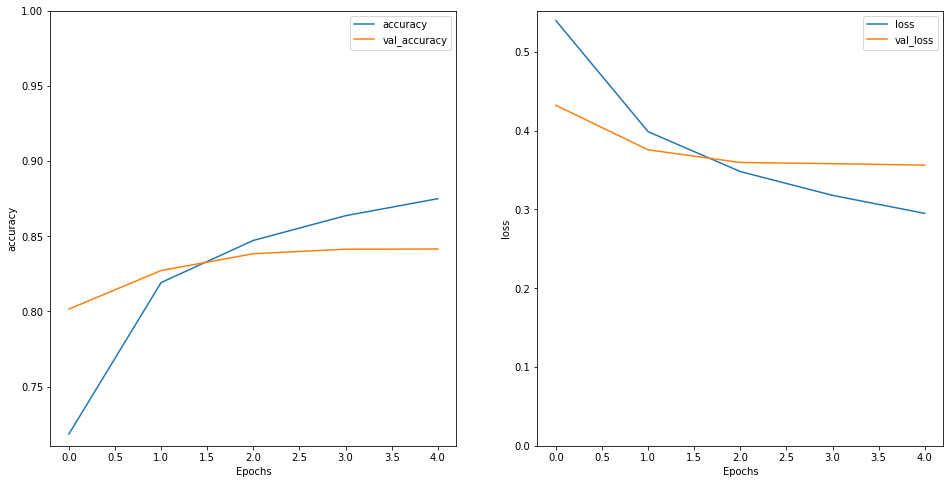

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### 모델2.  RNN LSTM 1레이어로 구성

In [20]:
from tensorflow.keras.initializers import Constant

model_LSTM1 = tf.keras.Sequential()
model_LSTM1.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_LSTM1.add(tf.keras.layers.Dense(64, activation='relu'))
model_LSTM1.add(tf.keras.layers.Dense(1))

In [21]:
print([layer.supports_masking for layer in model_LSTM1.layers])

[False, True, True, True]


In [22]:
model_LSTM1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model_LSTM1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
271/271 [==============================] - 8s 11ms/step - loss: 0.6075 - accuracy: 0.6210 - val_loss: 0.5165 - val_accuracy: 0.7397
Epoch 2/15
271/271 [==============================] - 2s 8ms/step - loss: 0.4910 - accuracy: 0.7485 - val_loss: 0.4517 - val_accuracy: 0.7798
Epoch 3/15
271/271 [==============================] - 2s 8ms/step - loss: 0.4421 - accuracy: 0.7818 - val_loss: 0.4222 - val_accuracy: 0.7992
Epoch 4/15
271/271 [==============================] - 2s 8ms/step - loss: 0.4115 - accuracy: 0.8003 - val_loss: 0.4021 - val_accuracy: 0.8155
Epoch 5/15
271/271 [==============================] - 2s 9ms/step - loss: 0.3889 - accuracy: 0.8144 - val_loss: 0.3838 - val_accuracy: 0.8184
Epoch 6/15
271/271 [==============================] - 2s 9ms/step - loss: 0.3703 - accuracy: 0.8242 - val_loss: 0.3765 - val_accuracy: 0.8211
Epoch 7/15
271/271 [==============================] - 2s 9ms/step - loss: 0.3555 - accuracy: 0.8328 - val_loss: 0.3653 - val_accuracy: 0.8283
Epoch

In [24]:
test_loss, test_acc = model_LSTM1.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3729 - accuracy: 0.8383
Test Loss: 0.3729386329650879
Test Accuracy: 0.8383139967918396


(0.0, 0.6236254781484604)

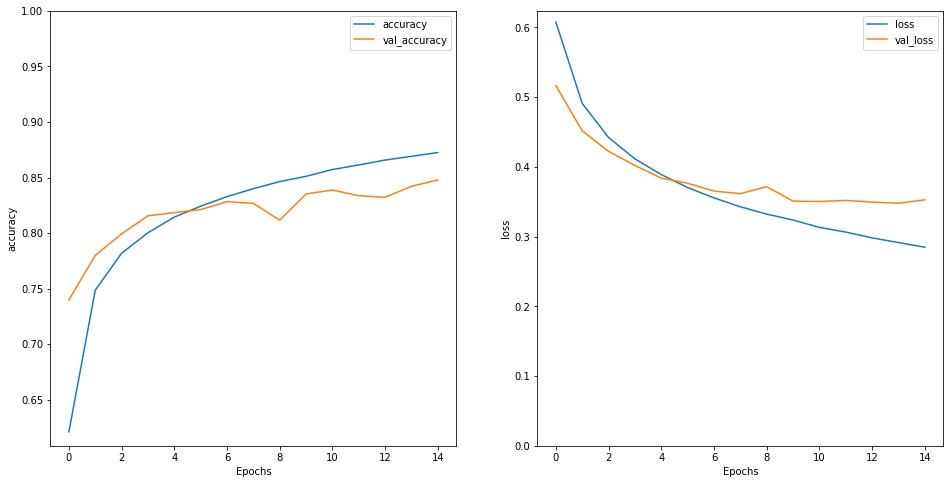

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### 모델3. RNN LSTM 2레이어로 구성

In [26]:
model_LSTM2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])



In [27]:
model_LSTM2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model_LSTM2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
271/271 [==============================] - 9s 16ms/step - loss: 0.6098 - accuracy: 0.6251 - val_loss: 0.5070 - val_accuracy: 0.7435
Epoch 2/15
271/271 [==============================] - 3s 12ms/step - loss: 0.4983 - accuracy: 0.7511 - val_loss: 0.4605 - val_accuracy: 0.7655
Epoch 3/15
271/271 [==============================] - 3s 12ms/step - loss: 0.4544 - accuracy: 0.7790 - val_loss: 0.4239 - val_accuracy: 0.7925
Epoch 4/15
271/271 [==============================] - 3s 12ms/step - loss: 0.4243 - accuracy: 0.7954 - val_loss: 0.4087 - val_accuracy: 0.7890
Epoch 5/15
271/271 [==============================] - 3s 12ms/step - loss: 0.4002 - accuracy: 0.8087 - val_loss: 0.3848 - val_accuracy: 0.8121
Epoch 6/15
271/271 [==============================] - 3s 12ms/step - loss: 0.3816 - accuracy: 0.8206 - val_loss: 0.3717 - val_accuracy: 0.8233
Epoch 7/15
271/271 [==============================] - 3s 12ms/step - loss: 0.3649 - accuracy: 0.8305 - val_loss: 0.3658 - val_accuracy: 0.8225

In [29]:
test_loss, test_acc = model_LSTM2.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1537/1537 [==============================] - 6s 4ms/step - loss: 0.3696 - accuracy: 0.8400
Test Loss: 0.3695651590824127
Test Accuracy: 0.8400431275367737


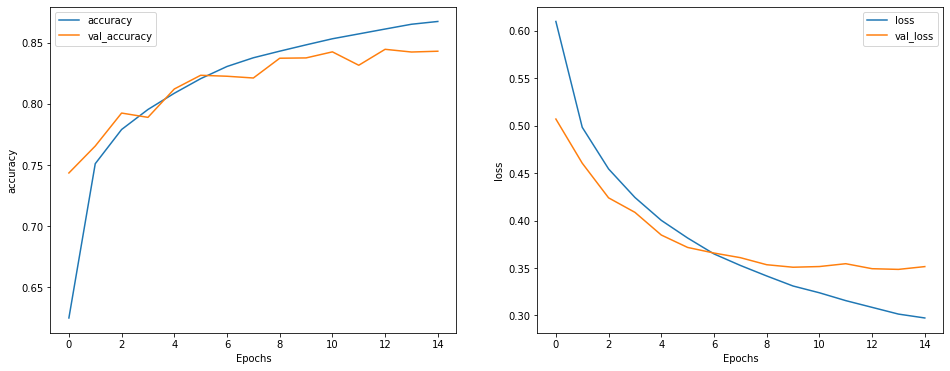

In [30]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### 모델별 영화평 호감도 예측 점수

#### Conv1D

In [31]:
sentences = ('ㅋㅋㅋ 난생처음 로그인하고 평점남기네요.. 개빡쳐서.. 알바들 속지마세요 이런 ㄱ ㅐ같은 시간낭비가. 아놔진짜평점 마이너스 별오만개',
             '최고최고! 바다까지! 4차원 고양이 로봇 도라에몽과 함께하는 진구와 친구들의 미지 탐험 이야기!우주꺼지 갔음 좋겠당~')
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.0021316]
 [0.9221747]]


#### LSTM1

In [32]:
sentences = ('ㅋㅋㅋ 난생처음 로그인하고 평점남기네요.. 개빡쳐서.. 알바들 속지마세요 이런 ㄱ ㅐ같은 시간낭비가. 아놔진짜평점 마이너스 별오만개',
             '최고최고! 바다까지! 4차원 고양이 로봇 도라에몽과 함께하는 진구와 친구들의 미지 탐험 이야기!우주꺼지 갔음 좋겠당~')
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[-4.603623 ]
 [ 2.6950054]]


#### LSTM2

In [33]:
sentences = ('ㅋㅋㅋ 난생처음 로그인하고 평점남기네요.. 개빡쳐서.. 알바들 속지마세요 이런 ㄱ ㅐ같은 시간낭비가. 아놔진짜평점 마이너스 별오만개',
             '최고최고! 바다까지! 4차원 고양이 로봇 도라에몽과 함께하는 진구와 친구들의 미지 탐험 이야기!우주꺼지 갔음 좋겠당~')
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[-5.7859592]
 [ 2.9964533]]


### 다른 영화평 예측점수

#### Conv1D

In [34]:
sentences = ('이런 쓰레기영화좀 만들지마라 진짜 재미없다ㅡㅡ',
             '정말 가슴아픈영화....질리지도 않는영화....몇번을봐도...음악도 너무 좋아요...OST도 구해 들었다는...')
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[9.847798e-04]
 [9.968829e-01]]


#### LSTM1

In [35]:
sentences = ('이런 쓰레기영화좀 만들지마라 진짜 재미없다ㅡㅡ',
             '정말 가슴아픈영화....질리지도 않는영화....몇번을봐도...음악도 너무 좋아요...OST도 구해 들었다는...')
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[-6.7472625]
 [ 7.851875 ]]


#### LSTM2

In [36]:
sentences = ('이런 쓰레기영화좀 만들지마라 진짜 재미없다ㅡㅡ',
             '정말 가슴아픈영화....질리지도 않는영화....몇번을봐도...음악도 너무 좋아요...OST도 구해 들었다는...')
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[-5.986865 ]
 [ 6.4737434]]


### 한국어 Word2Vec 임베딩 활용하여 성능 개선
#### 사용된 세개의 모델 전부 Word2Vec 사용

#### 참고 : RNN을 사용한 텍스트 분류
https://www.tensorflow.org/text/tutorials/text_similarity?hl=ko

###  후 기 :  

####  Conv1D 보다는 LSTM1이 LSTM1 보다는 LSTM2가 좀더 주관적인 평가에 근접하는 점수를 내주었다.

#### 한국어 형태소 분류하는 프로그램의 성능이 기대에 미치지 못했고 문장의 대부분 단어들이 무시되는 결과가 되었다. 

#### 영어 같은 문장구조라면 비교적 쉬운 작업이 될 거라고 생각되지만 한국어는 컴퓨터 환경에서 '정말 너무 구리다'

#### 영어를 사용하는 영화평 감성분류 작업도 정확도가 85% 정도 나오던데 한국어 작업결과가 83% 이렇게 비슷하게 나와도 결과를 직접 확인해보면 기대에 미치지 못한다.
    
#### 차라리 문장을 통체로 딥러닝 시도하는 것이 나을 것 같다.    
    
